In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as iplot
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data=pd.read_csv(r"F:\FYP-II-master\data\training.csv")
data.head()

,class,text,Unnamed: 2
0,PI,What's the difference between the iPhone X a...,NaN
1,no,@ siracusa just listened to Hypercritical #16...,NaN
2,PI,Same. IPhone X won't be bad https:// twitt...,NaN
3,no,Ive had the iphone 8 plus and iphone x and i...,NaN
4,no,“ iphone x for £150” do i have dickhead writ...,NaN


## Exploratory data analysis

In [3]:
data.shape
data.isnull().sum()

class            0
text             0
Unnamed: 2    1682
dtype: int64

## Data preprocessing

In [4]:
data=data.drop(columns=['Unnamed: 2'])

In [5]:
data['class']=data['class'].replace(['Undefined','undefined'],'un')
data=data[data['class']!='un']
data.head(10)


,class,text
0,PI,What's the difference between the iPhone X a...
1,no,@ siracusa just listened to Hypercritical #16...
2,PI,Same. IPhone X won't be bad https:// twitt...
3,no,Ive had the iphone 8 plus and iphone x and i...
4,no,“ iphone x for £150” do i have dickhead writ...
5,PI,This iPhone X still very sexy a year later
7,PI,If not I'm using my kidney. Omo what is ferrar...
8,PI,iPhone X 's max for sale
9,no,Someone once told me that.....\n\nBut I've nev...
10,PI,screenshots from the iphone x look so clapped


In [6]:
data['class']=data['class'].replace(['no','No'],0)
data['class']=data['class'].replace(['Pl','PI','yes','Yes'],1)
data_test=data
data.head(10)

,class,text
0,1,What's the difference between the iPhone X a...
1,0,@ siracusa just listened to Hypercritical #16...
2,1,Same. IPhone X won't be bad https:// twitt...
3,0,Ive had the iphone 8 plus and iphone x and i...
4,0,“ iphone x for £150” do i have dickhead writ...
5,1,This iPhone X still very sexy a year later
7,1,If not I'm using my kidney. Omo what is ferrar...
8,1,iPhone X 's max for sale
9,0,Someone once told me that.....\n\nBut I've nev...
10,1,screenshots from the iphone x look so clapped


In [7]:
data.shape
print(data['text'][1])

@ siracusa  just listened to Hypercritical #16, whole episode about LCD ghosting and how horrible it is. Doesn't the OLED ghosting annoy you? It drives me crazy every time I scroll black backgrounds on an  iPhone X {,s}


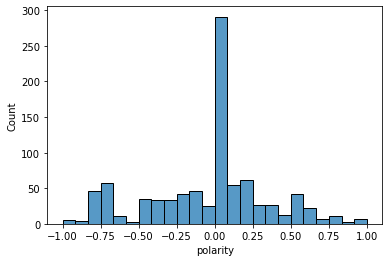

<AxesSubplot:xlabel='subjectivity', ylabel='Count'>

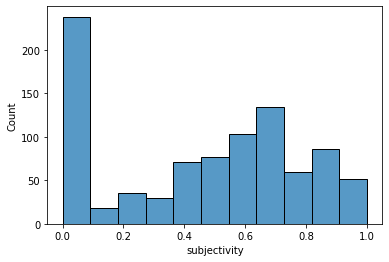

In [8]:
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_analysis(text):
    return TextBlob(text).sentiment.subjectivity
data_test=data
data_test['polarity']=data_test['text'].apply(sentiment_analysis)
data_test['subjectivity']=data_test['text'].apply(subjectivity_analysis)
data_test
sns.histplot(data['polarity'])
plt.show()
sns.histplot(data['subjectivity'])

## Text Preprocessing

In [9]:
replace_space=re.compile('[/(){}\[\]\|@,;]')
replace_bad_symbol=re.compile('[^0-9a-z #+_]')
Stopwords=set(stopwords.words('english'))

In [10]:
def clean_text(text):
    text=text.lower()
    text=replace_space.sub(' ',text)
    text=replace_bad_symbol.sub('',text)

    text=' '.join(word for word in text.split() if word not in Stopwords)
    return text

data['text']=data['text'].apply(clean_text)
data.head(10)

,class,text,polarity,subjectivity
0,1,whats difference iphone x iphone x x max,0.000000,0.000000
1,0,siracusa listened hypercritical #16 whole epis...,-0.391667,0.683333
2,1,iphone x wont bad https twittercom afuaasam st...,-0.350000,0.395833
3,0,ive iphone 8 plus iphone x id say iphone 8 plu...,0.500000,0.500000
4,0,iphone x 150 dickhead written,0.000000,0.000000
5,1,iphone x still sexy year later,0.325000,0.500000
7,1,im using kidney omo ferrari buggati iphone x m...,0.136364,0.500000
8,1,iphone x max sale,0.000000,0.000000
9,0,someone told thatbut ive never seen ios turned...,0.200000,0.400000
10,1,screenshots iphone x look clapped,0.000000,0.000000


In [11]:
t=Tokenizer(num_words=50000,lower=True)
t.fit_on_texts(data['text'])
x=t.texts_to_sequences(data['text'])
x=sequence.pad_sequences(x,maxlen=250)
print(x.shape)
print(x)

(904, 250)
[[   0    0    0 ...    2    2  116]
 [   0    0    0 ...  878    1    2]
 [   0    0    0 ...  879  266  880]
 ...
 [   0    0    0 ...    3  260   11]
 [   0    0    0 ...    1    2    8]
 [   0    0    0 ...  513 2335  641]]


## calculate sentiment and subjectivity of tweets

#### subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. TextBlob has one more parameter — intensity. TextBlob calculates subjectivity by looking at the ‘intensity’. Intensity determines if a word modifies the next word. For English, adverbs are used as modifiers (‘very good’).  Subjectivity lies between [0,1].

#### Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. Negation words reverse the polarity

In [12]:
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_analysis(text):
    return TextBlob(text).sentiment.subjectivity
data_sample=data
data_sample['polarity']=data_sample['text'].apply(sentiment_analysis)
data_sample['subjectivity']=data_sample['text'].apply(subjectivity_analysis)
data_sample

,class,text,polarity,subjectivity
0,1,whats difference iphone x iphone x x max,0.000000,0.000000
1,0,siracusa listened hypercritical #16 whole epis...,-0.391667,0.683333
2,1,iphone x wont bad https twittercom afuaasam st...,-0.700000,0.666667
3,0,ive iphone 8 plus iphone x id say iphone 8 plu...,0.500000,0.500000
4,0,iphone x 150 dickhead written,0.000000,0.000000
...,...,...,...,...
1675,0,ew iphone 7s camera quality looks trash next x...,-0.400000,0.500000
1677,0,apple hey brand new expensive iphone x suck ca...,0.112121,0.584848
1678,0,unpopular opinion hate iphone x models yet won...,-0.800000,0.900000
1681,1,want iphone x bad,-0.700000,0.666667


In [13]:
def count_words(text):
    l=text.split()
    return len(l)
data_sample['word_count']=data_sample['text'].apply(count_words)
data_sample

,class,text,polarity,subjectivity,word_count
0,1,whats difference iphone x iphone x x max,0.000000,0.000000,8
1,0,siracusa listened hypercritical #16 whole epis...,-0.391667,0.683333,22
2,1,iphone x wont bad https twittercom afuaasam st...,-0.700000,0.666667,9
3,0,ive iphone 8 plus iphone x id say iphone 8 plu...,0.500000,0.500000,13
4,0,iphone x 150 dickhead written,0.000000,0.000000,5
...,...,...,...,...,...
1675,0,ew iphone 7s camera quality looks trash next x...,-0.400000,0.500000,11
1677,0,apple hey brand new expensive iphone x suck ca...,0.112121,0.584848,14
1678,0,unpopular opinion hate iphone x models yet won...,-0.800000,0.900000,11
1681,1,want iphone x bad,-0.700000,0.666667,4


## Data Visualization

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='word_count', ylabel='Count'>

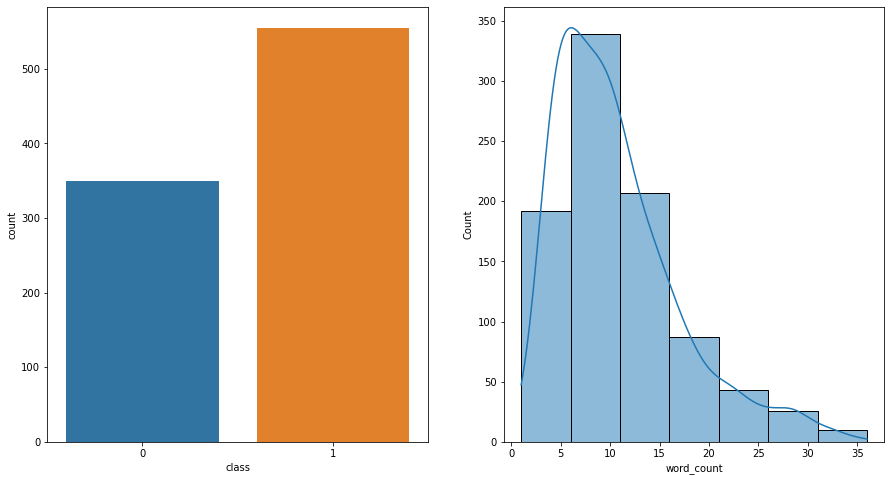

In [14]:
plt.rcParams['figure.figsize']=(15,8)
f,axes=plt.subplots(1,2)
sns.countplot(data['class'],ax=axes[0])
sns.histplot(data,x='word_count',binwidth=5,kde=True)

<AxesSubplot:xlabel='polarity', ylabel='Count'>

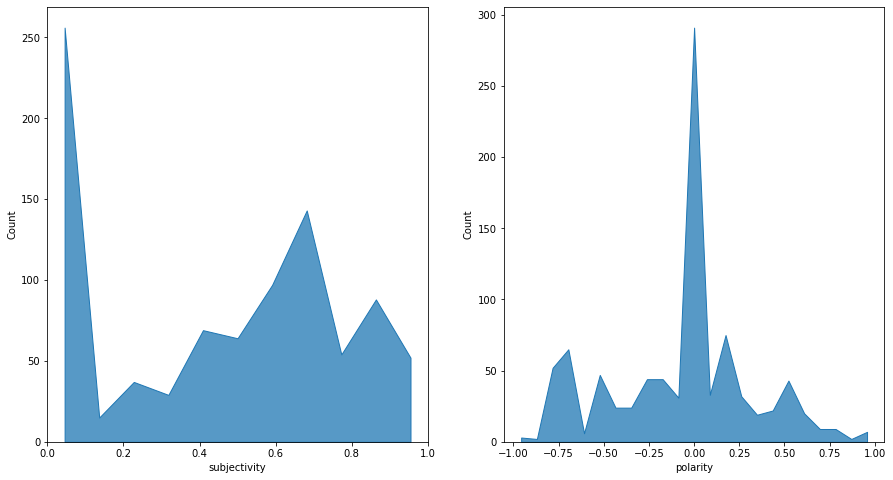

In [15]:
plt.rcParams['figure.figsize']=(15,8)
f,axes=plt.subplots(1,2)
sns.histplot(data=data_sample,x='subjectivity',element="poly",ax=axes[0])
sns.histplot(data=data_sample,x='polarity',element="poly")

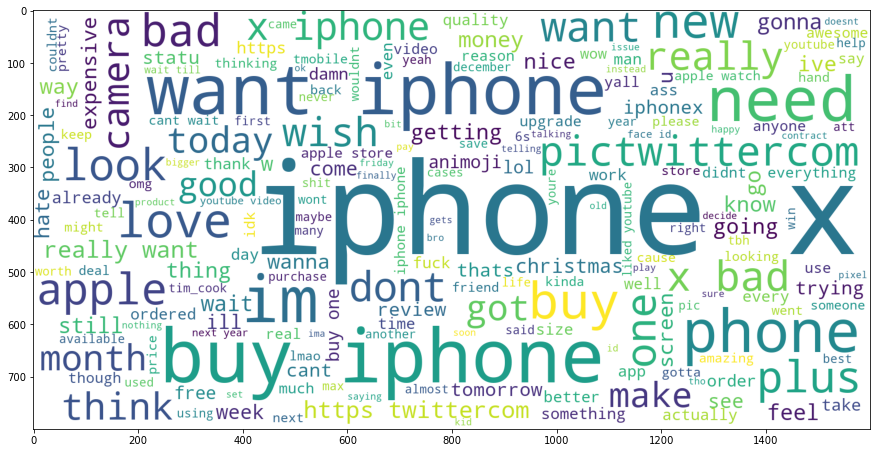

In [16]:
# visualize most recuring words in purchase intent and non purchase intent tweets
data_pi=data[data['class']==1]
data_no=data[data['class']==0]
wc=WordCloud(background_color='white',width=1600, height=800)
wc.generate(" ".join(data_pi['text']))
wc2=WordCloud(background_color='white',width=1600, height=800)
wc2.generate(" ".join(data_no['text']))
plt.imshow(wc)

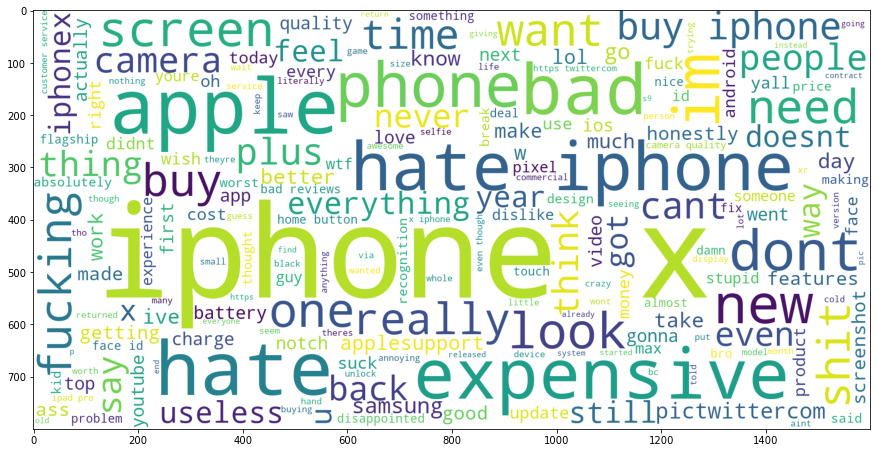

In [17]:
plt.imshow(wc2)

## Spliting of dataset

In [18]:
y=pd.get_dummies(data['class']).values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
y

(813, 250) (91, 250)
(813, 2) (91, 2)


array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]], dtype=uint8)

## Training LSTM model

In [39]:
model=Sequential()
model.add(Embedding(50000,100,input_length=x.shape[1]))
# model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

fit=model.fit(x_train,y_train,epochs=7,batch_size=32,validation_split=0.1)

Epoch 1/7
23/23 [==============================] - 14s 472ms/step - loss: 0.6738 - accuracy: 0.5957 - val_loss: 0.7203 - val_accuracy: 0.5488
Epoch 2/7
23/23 [==============================] - 12s 540ms/step - loss: 0.5943 - accuracy: 0.6570 - val_loss: 0.6621 - val_accuracy: 0.5854
Epoch 3/7
23/23 [==============================] - 14s 595ms/step - loss: 0.3352 - accuracy: 0.8813 - val_loss: 0.7150 - val_accuracy: 0.7439
Epoch 4/7
23/23 [==============================] - 13s 578ms/step - loss: 0.2558 - accuracy: 0.9427 - val_loss: 0.6947 - val_accuracy: 0.7317
Epoch 5/7
23/23 [==============================] - 13s 584ms/step - loss: 0.1170 - accuracy: 0.9680 - val_loss: 0.8503 - val_accuracy: 0.7195
Epoch 6/7
23/23 [==============================] - 13s 548ms/step - loss: 0.1057 - accuracy: 0.9653 - val_loss: 0.8049 - val_accuracy: 0.7073
Epoch 7/7
23/23 [==============================] - 13s 569ms/step - loss: 0.1163 - accuracy: 0.9726 - val_loss: 0.9547 - val_accuracy: 0.6098


In [40]:
acr=model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 131ms/step - loss: 0.8173 - accuracy: 0.6593


In [21]:
y_test

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1,

In [22]:
# cal=t.texts_to_sequences(test)
cal=sequence.pad_sequences(x,maxlen=250)
pred=model.predict_classes(x_test)
pred=np.reshape(pred,(len(pred),1))
pred

C:\Users\Lenovo\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [23]:
y=list(y_test)
y2=[]
for i in range(len(y)):
    if y[i][0]==1:
        y2.append(0)
    else:
        y2.append(1)
len(y2)

91

In [24]:
y_true = y2
y_pred = list(pred)
target_names = ['no','yes']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          no       0.64      0.73      0.68        37
         yes       0.80      0.72      0.76        54

    accuracy                           0.73        91
   macro avg       0.72      0.73      0.72        91
weighted avg       0.73      0.73      0.73        91



In [41]:
x=t.texts_to_sequences(["I want an iphone x badly"])
x=sequence.pad_sequences(x,maxlen=250)
p=model.predict_classes(x)
p=np.reshape(p,(len(p),1))
p

array([[1]], dtype=int64)